In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator.lmfit_resonator import LinearResonatorWithCable, LinearLossResonatorWithCable

In [4]:
npd = npy.NumpyDirectory('/data/detectors/2017-03-06_182649_preliminary_high_power.npd/')

In [5]:
swp_list = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweep') and not 'Stream' in name]
sss_list = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStream')]
snap_list = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]
print([(snap.x.ptp(), snap.y.ptp()) for snap in snap_list])

[(4083.0, 4024.0), (2502.0, 2290.0), (1149.0, 1332.0), (638.0, 592.0), (312.0, 329.0), (3923.0, 3802.0), (2114.0, 2074.0), (1039.0, 1104.0), (508.0, 582.0), (256.0, 319.0), (2817.0, 2517.0), (1254.0, 1271.0), (707.0, 622.0), (343.0, 323.0), (182.0, 170.0), (1668.0, 1657.0), (865.0, 826.0), (452.0, 421.0), (233.0, 220.0), (125.0, 120.0), (1468.0, 1390.0), (770.0, 725.0), (392.0, 367.0), (185.0, 179.0), (99.0, 97.0), (892.0, 903.0), (456.0, 463.0), (240.0, 228.0), (120.0, 115.0), (65.0, 60.0)]


In [6]:
swp_dict = defaultdict(list)
sss_dict = defaultdict(list)
for swp, sss in zip(swp_list, sss_list):
    swp_dict[sss.state.lo_index].append(swp)
    sss_dict[sss.state.lo_index].append(sss)

In [7]:
num_channels = len(sss_dict.keys())
num_attenuations = np.max([len(list_) for list_ in sss_dict.values()])

# Resonator model

In [9]:
for swp in swp_list:
    swp.fit_resonator(model=LinearResonatorWithCable)
for sss in sss_list:
    sss.sweep.fit_resonator(model=LinearResonatorWithCable)

# Tone centering

In [10]:
assert np.all([sss.stream.tone_offset_frequency()[sss.stream.tone_index] == 0 for sss in sss_list])

# Forward scattering versus frequency

In [11]:
s21_vs_f = {'xlabel': 'frequency / MHz',
            'ylabel': '$|S_{21}|^2$ / dB',
            'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$'}

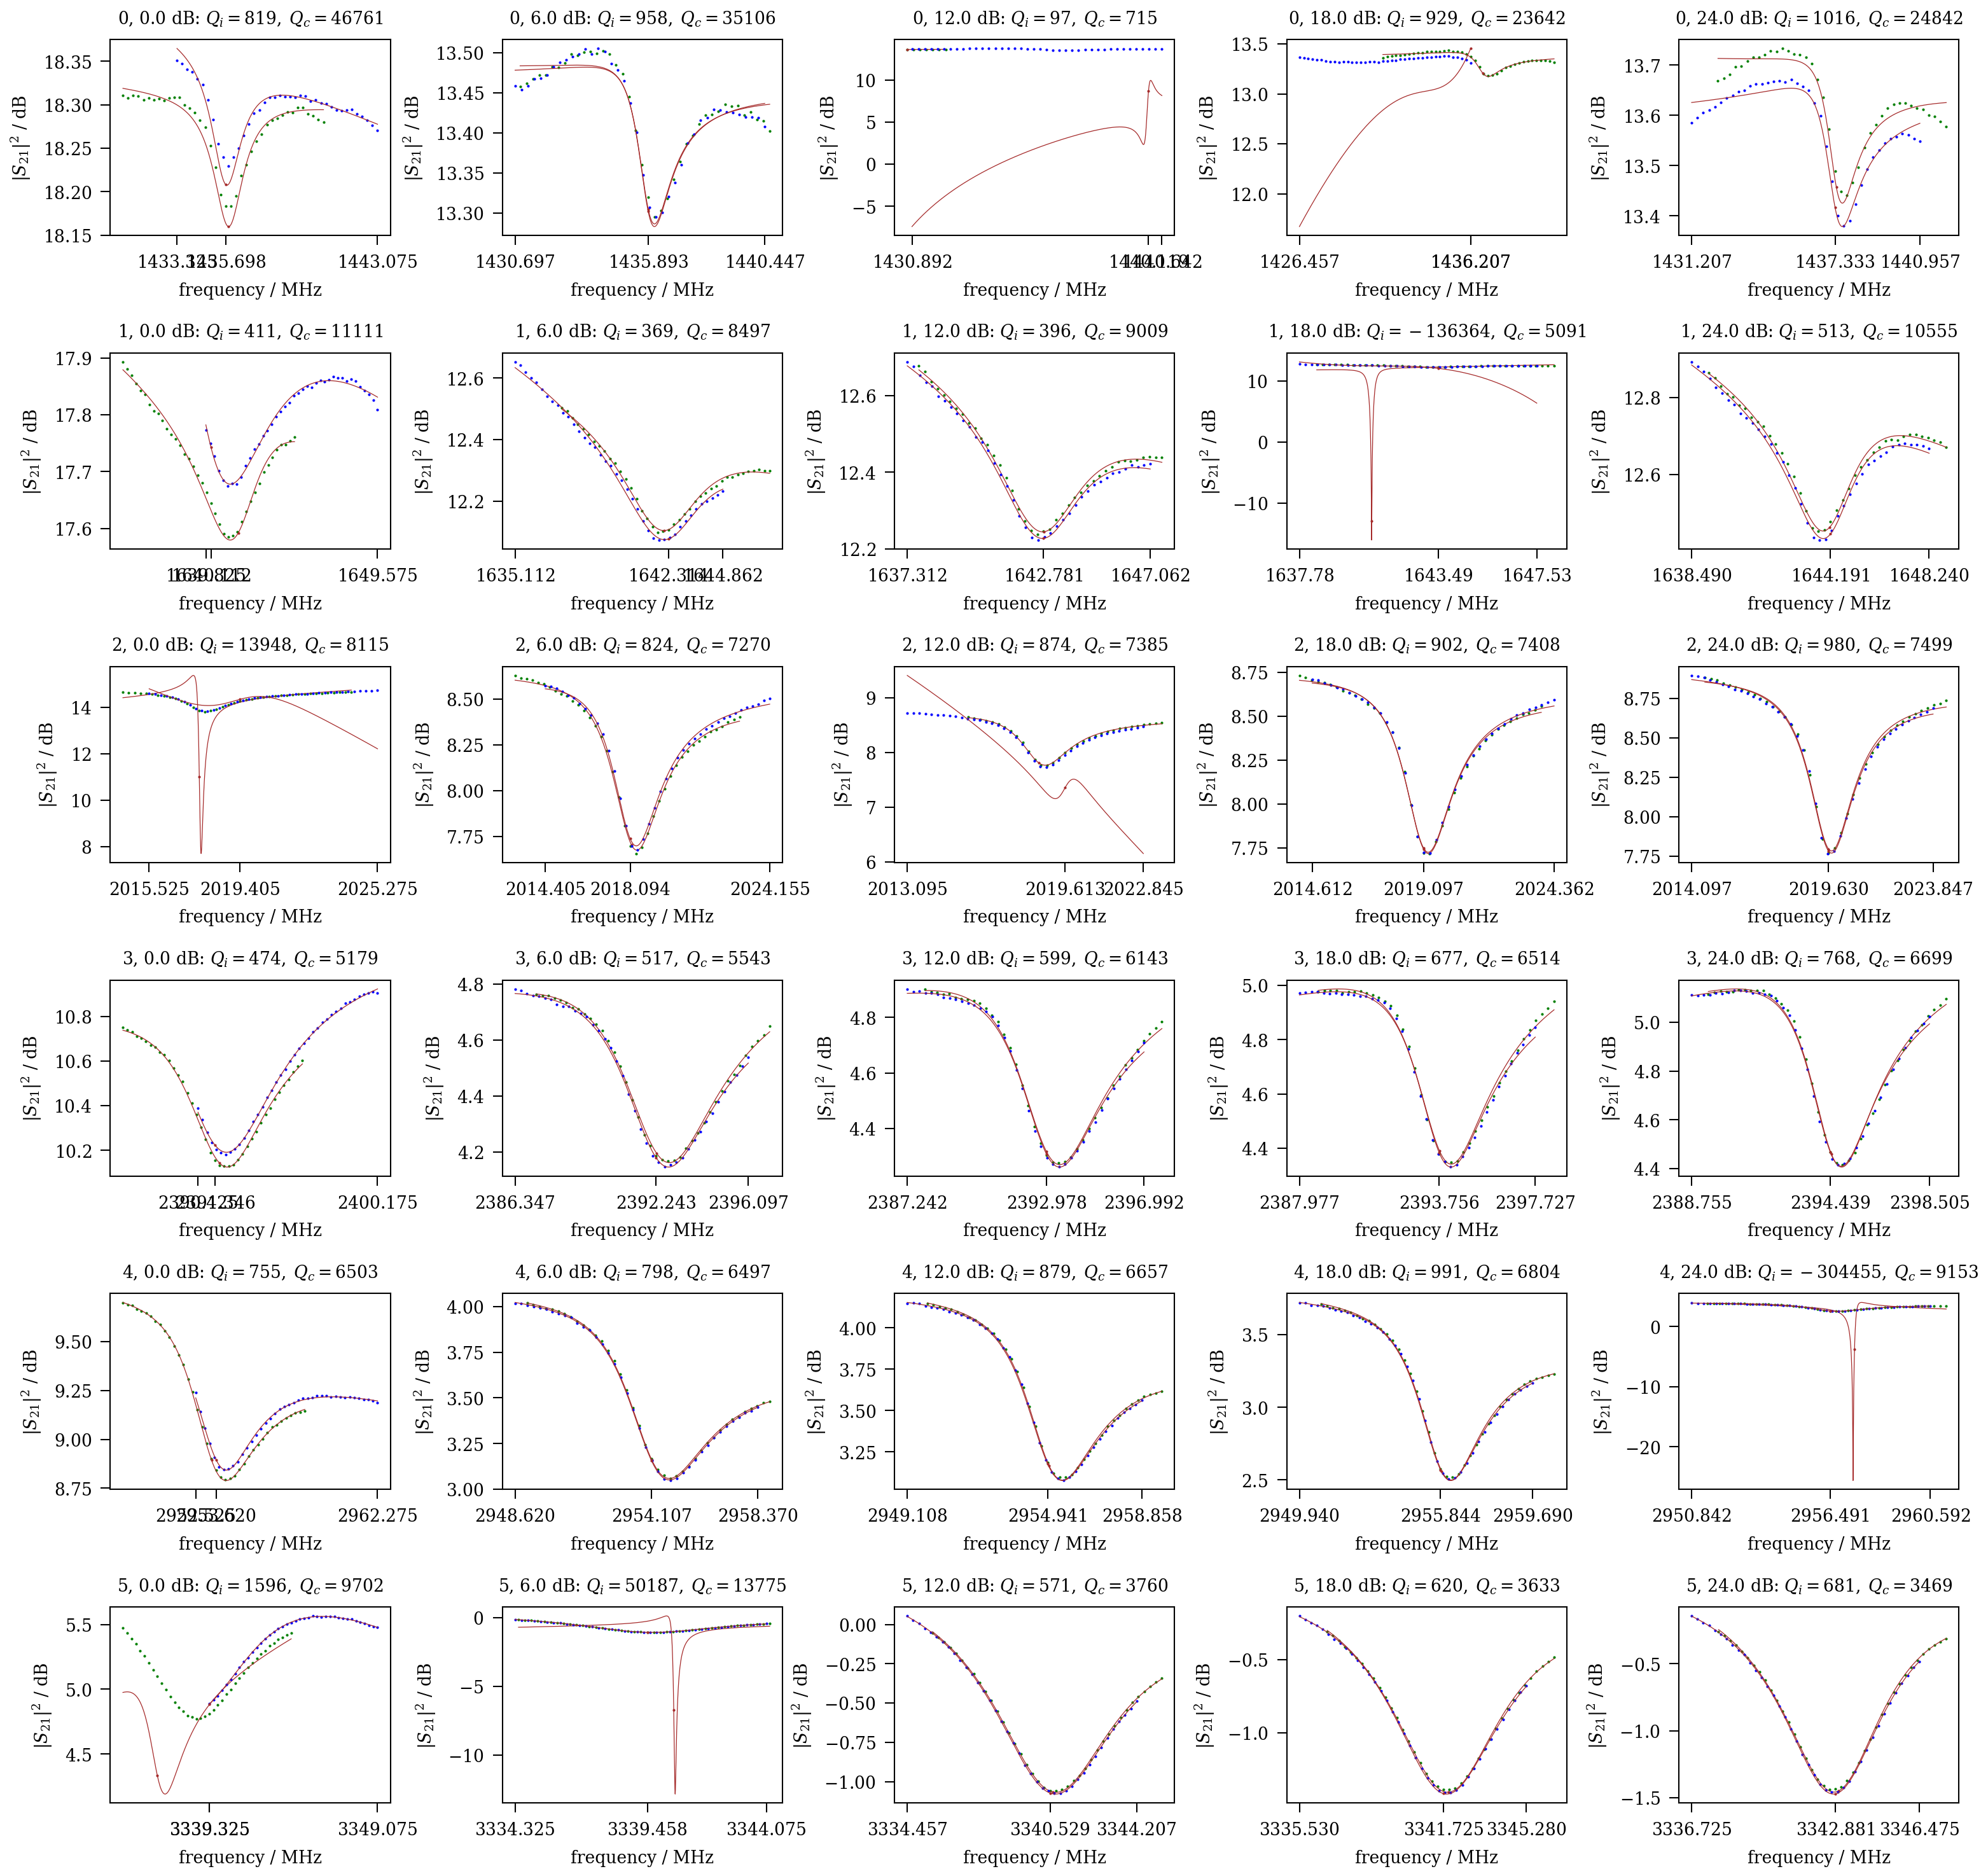

In [15]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for swp, sss, ax in zip(swp_dict[lo_index], sss_dict[lo_index], axes[lo_index, :]):
        ax.tick_params(labelsize='xx-small')
        ax.set_xlabel(s21_vs_f['xlabel'], fontsize='xx-small')
        ax.set_ylabel(s21_vs_f['ylabel'], fontsize='xx-small')
        plot_basic.resonator_amplitude(sss.resonator, ax, normalize=False, sweep_mean_settings={'color': 'green'})
        plot_basic.resonator_amplitude(swp.resonator, ax, normalize=False)
        ax.set_title(s21_vs_f['title'].format(
            lo_index, sss.stream.roach_state.dac_attenuation, sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')

# Forward scattering in the complex plane

In [13]:
s21_complex = {'xlabel': 'Re $S_{21}$',
               'ylabel': 'Im $S_{21}$',
               'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$'}

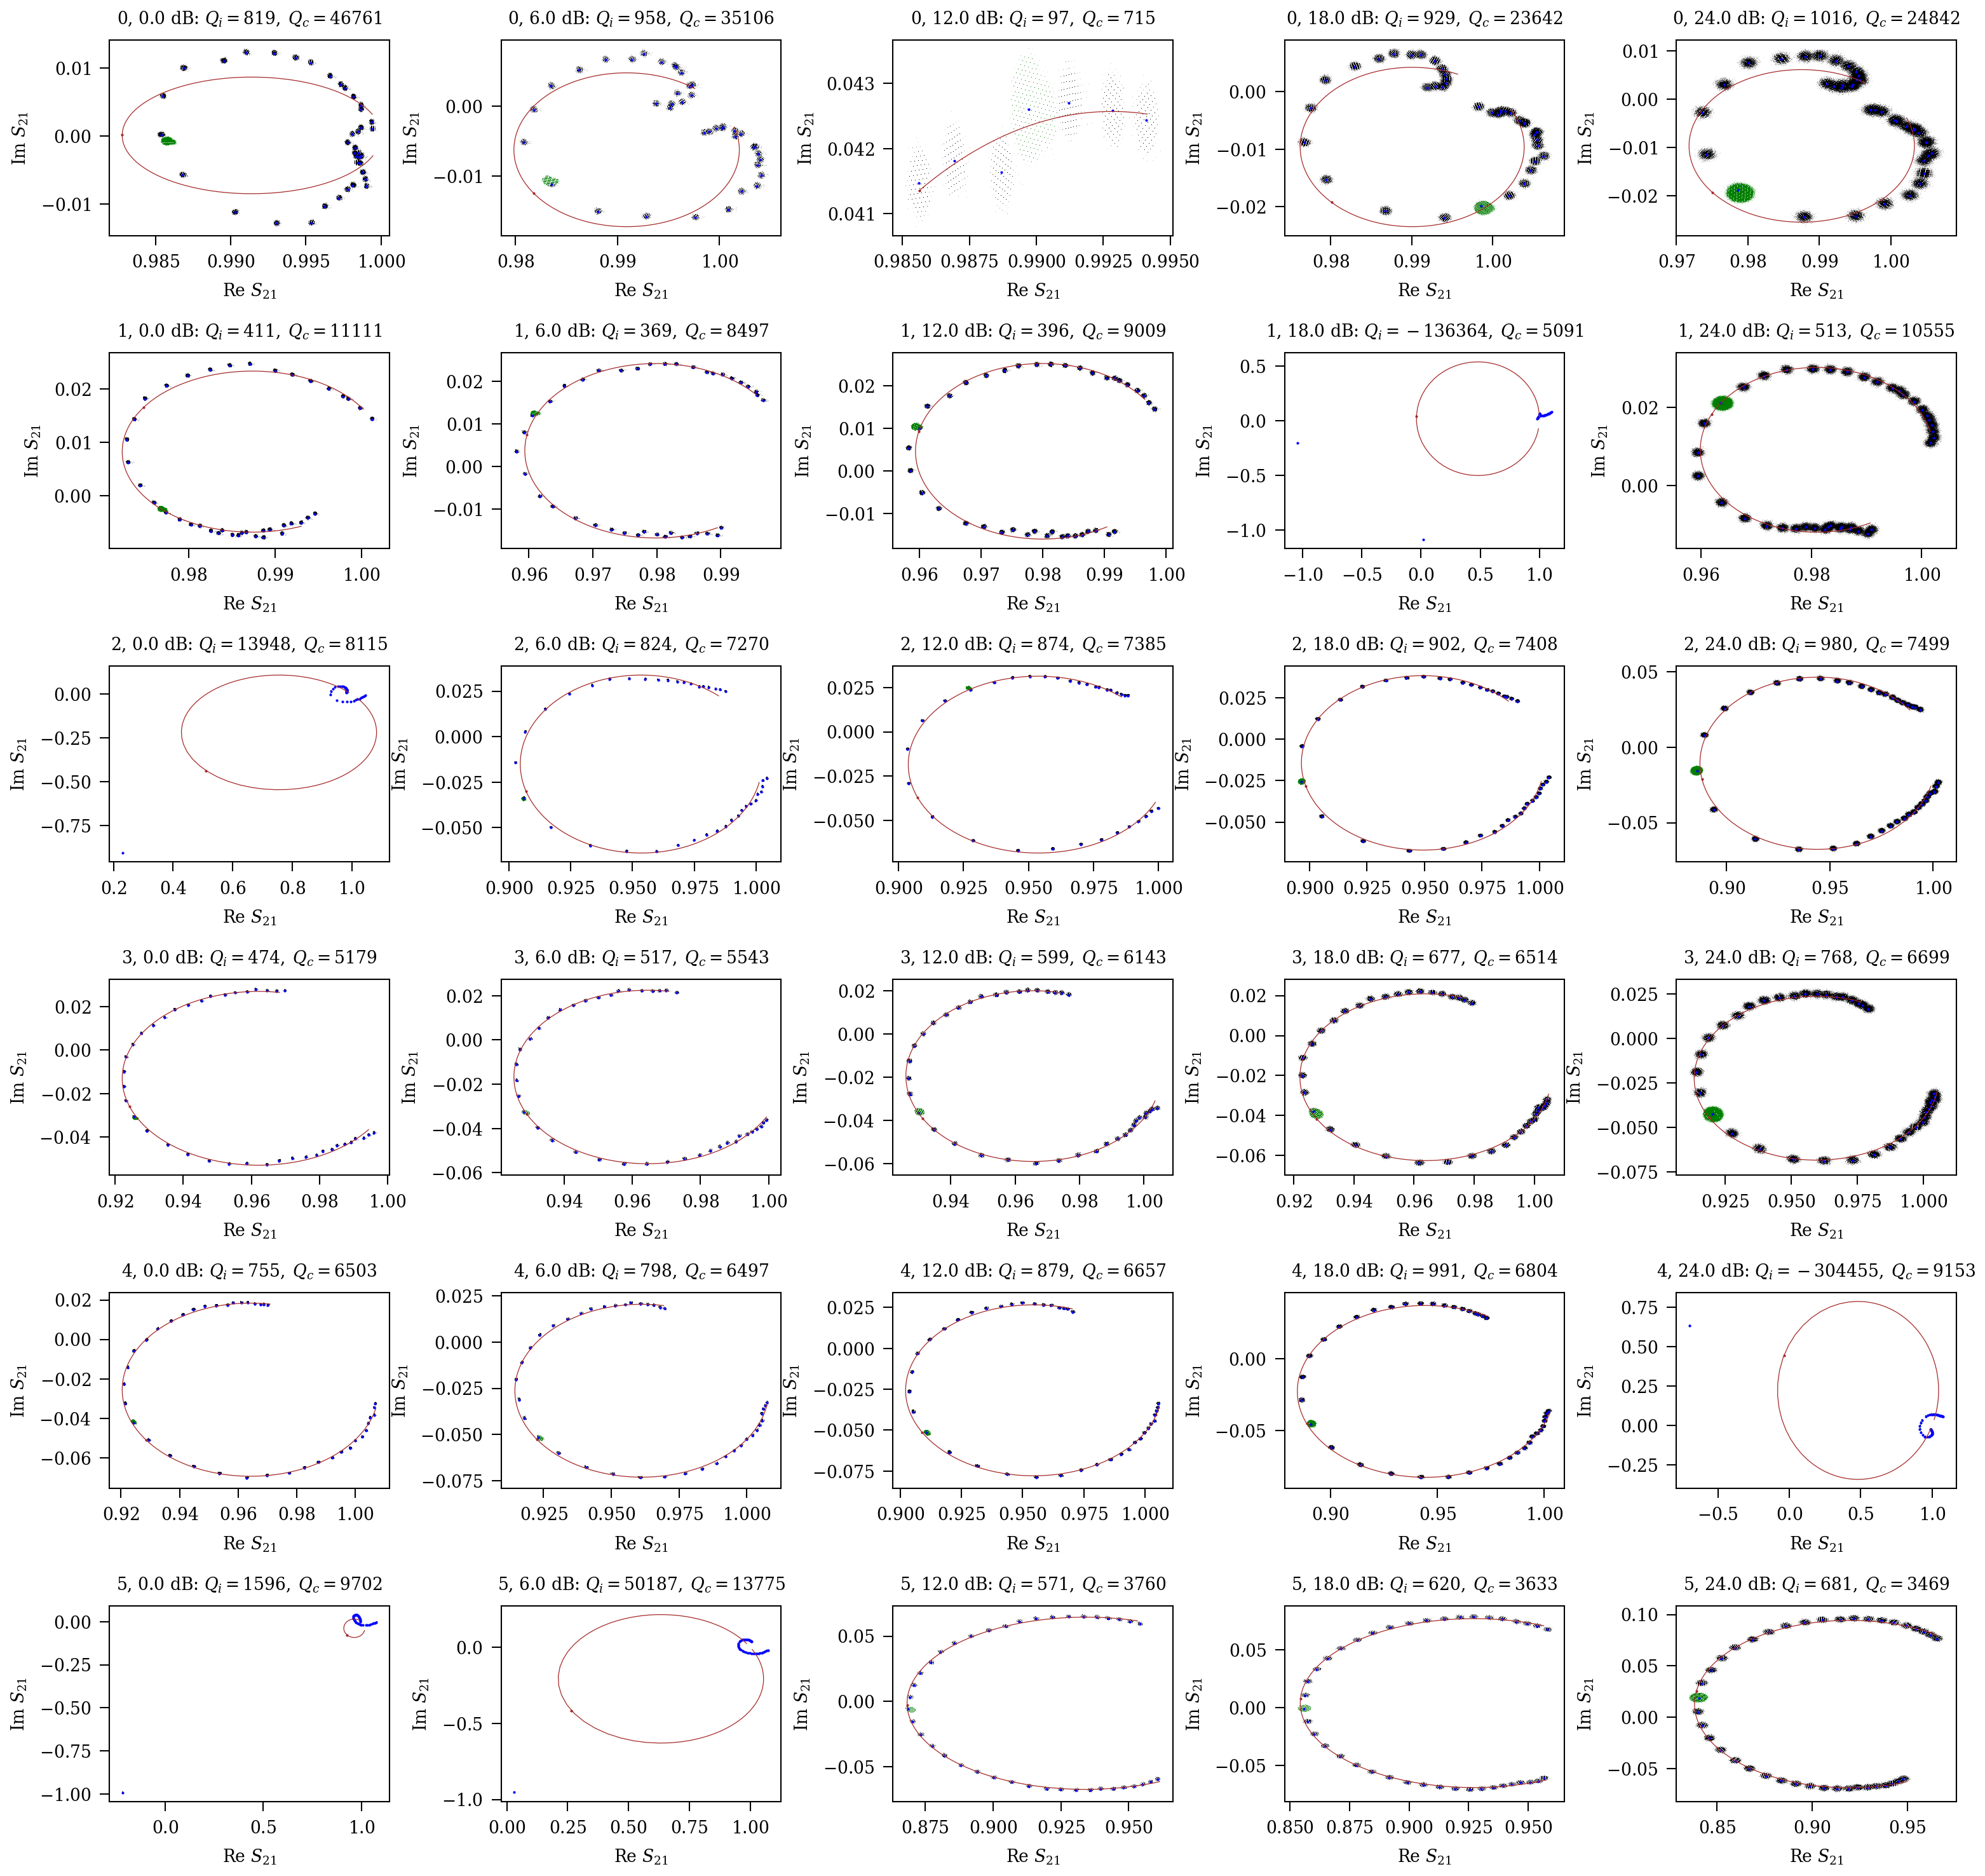

In [14]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for swp, sss, ax in zip(swp_dict[lo_index], sss_dict[lo_index], axes[lo_index, :]):
        ax.tick_params(labelsize='xx-small')
        ax.set_xlabel(s21_complex['xlabel'], fontsize='xx-small')
        ax.set_ylabel(s21_complex['ylabel'], fontsize='xx-small')
        plot_basic.sss_complex_plane(sss, ax, normalize=True)
        ax.set_title(s21_complex['title'].format(
            lo_index, sss.stream.roach_state.dac_attenuation, sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')

# $S_{xx}$ and $S_{yy}$

In [ ]:
xx_and_yy = {'xlabel': 'frequency / Hz',
             'ylabel': 'spectral density / Hz$^{-1}$',
             'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$',
             'Sxx_label': '$S_{xx}$',
             'Syy_label': '$S_{yy}$'}

In [ ]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for sss, ax in zip(sss_dict[lo_index], axes[lo_index, :]):
        ax.set_xlabel(xx_and_yy['xlabel'], fontsize='xx-small')
        ax.set_ylabel(xx_and_yy['ylabel'], fontsize='xx-small')
        ax.set_title(xx_and_yy['title'].format(lo_index, sss.stream.roach_state.dac_attenuation, 
                                               sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(sss.S_frequency, sss.S_xx, label=xx_and_yy['Sxx_label'])
        ax.plot(sss.S_frequency, sss.S_yy, label=xx_and_yy['Syy_label'])
        ax.tick_params(labelsize='xx-small')
        ax.legend(fontsize='xx-small');

# $S_{xx} - S_{yy}$

In [ ]:
xx_minus_yy = {'xlabel': 'frequency / Hz',
               'ylabel': 'spectral density / Hz$^{-1}$',
               'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$',
               'label': '$S_{xx} - S_{yy}$'}

In [ ]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for sss, ax in zip(sss_dict[lo_index], axes[lo_index, :]):
        ax.tick_params(labelsize='xx-small')
        ax.set_xlabel(xx_and_yy['xlabel'], fontsize='xx-small')
        ax.set_ylabel(xx_and_yy['ylabel'], fontsize='xx-small')
        ax.set_title(xx_and_yy['title'].format(lo_index, sss.stream.roach_state.dac_attenuation, 
                                               sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(sss.S_frequency, sss.S_xx - sss.S_yy, label=xx_minus_yy['label'])
        ax.legend(fontsize='xx-small', ncol=1, bbox_to_anchor=(1, 1));